# Data analysis 
The training of the models is based on the `MASSIVE` dataset by AmazonSciece |  it contains over 10.000 italain sentences which are classified as a request for an interpreter.

Each entry of the dataset is tructured as follow:

| `id` | `locale` | `partition` | `scenario` | `intent` | `utt` | `annot_utt` |


## Classification and labeling
The first  intres is the classification problem: I wanto that the `classifier model` to be able to predict the aim (which is the label in the dataset) of a general sentence.

This must help the program to define what the user want it to do an invoke the right handler. Therefore the precison in labeling is crucial fro the sistem's performance.

The MASSIVE dataset introduces a series of lable (called *intent*), which the model intend to predict.




<Axes: xlabel='count', ylabel='intent'>

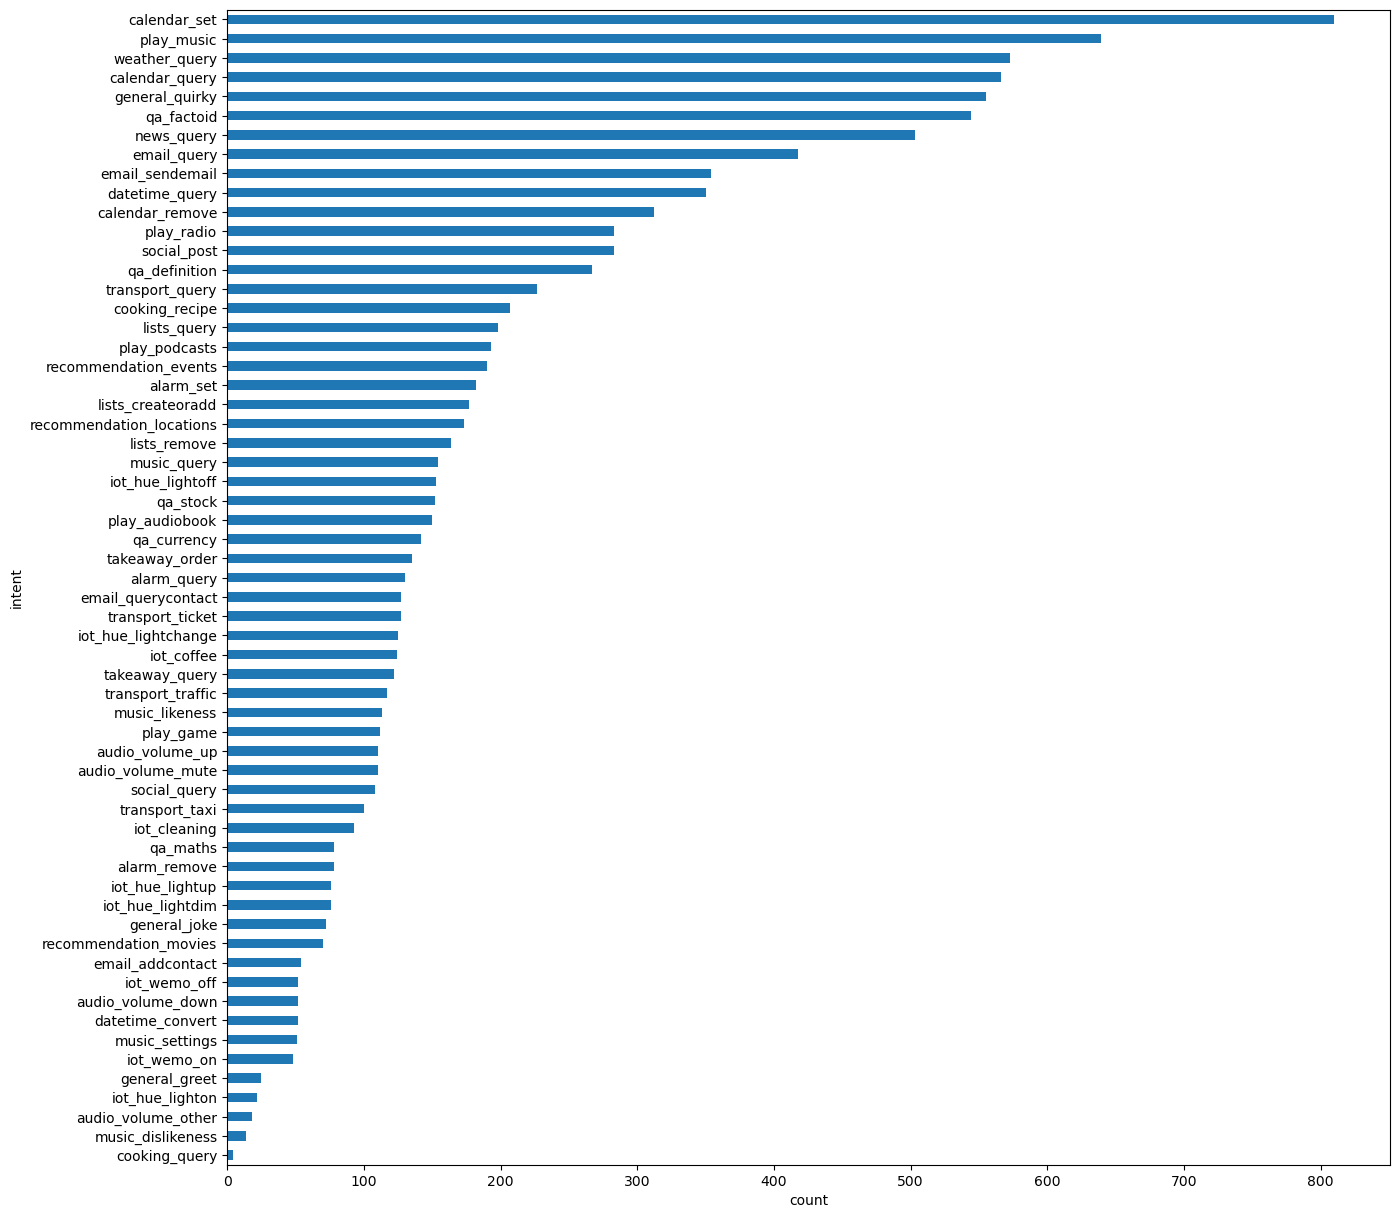

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

ds = pd.read_csv('MASSIVE_dataset\massive_it_train.csv')
intents = ds['intent']
freq_intent = intents.value_counts().sort_values()
freq_intent.plot(kind='barh', figsize=(15,15), ylabel='intent', xlabel='count')

as notable, the labels are not equaly distributer: the model trained will bel much less acurate in regard of the classification of querys that fall in the more rare labels.

Nevertheless, those are also the rarest kind of quarys the user may ask, therfore the option of **oversempleing** is (for now) discarded.

### Entropy




entropy for the intents: -5.4117


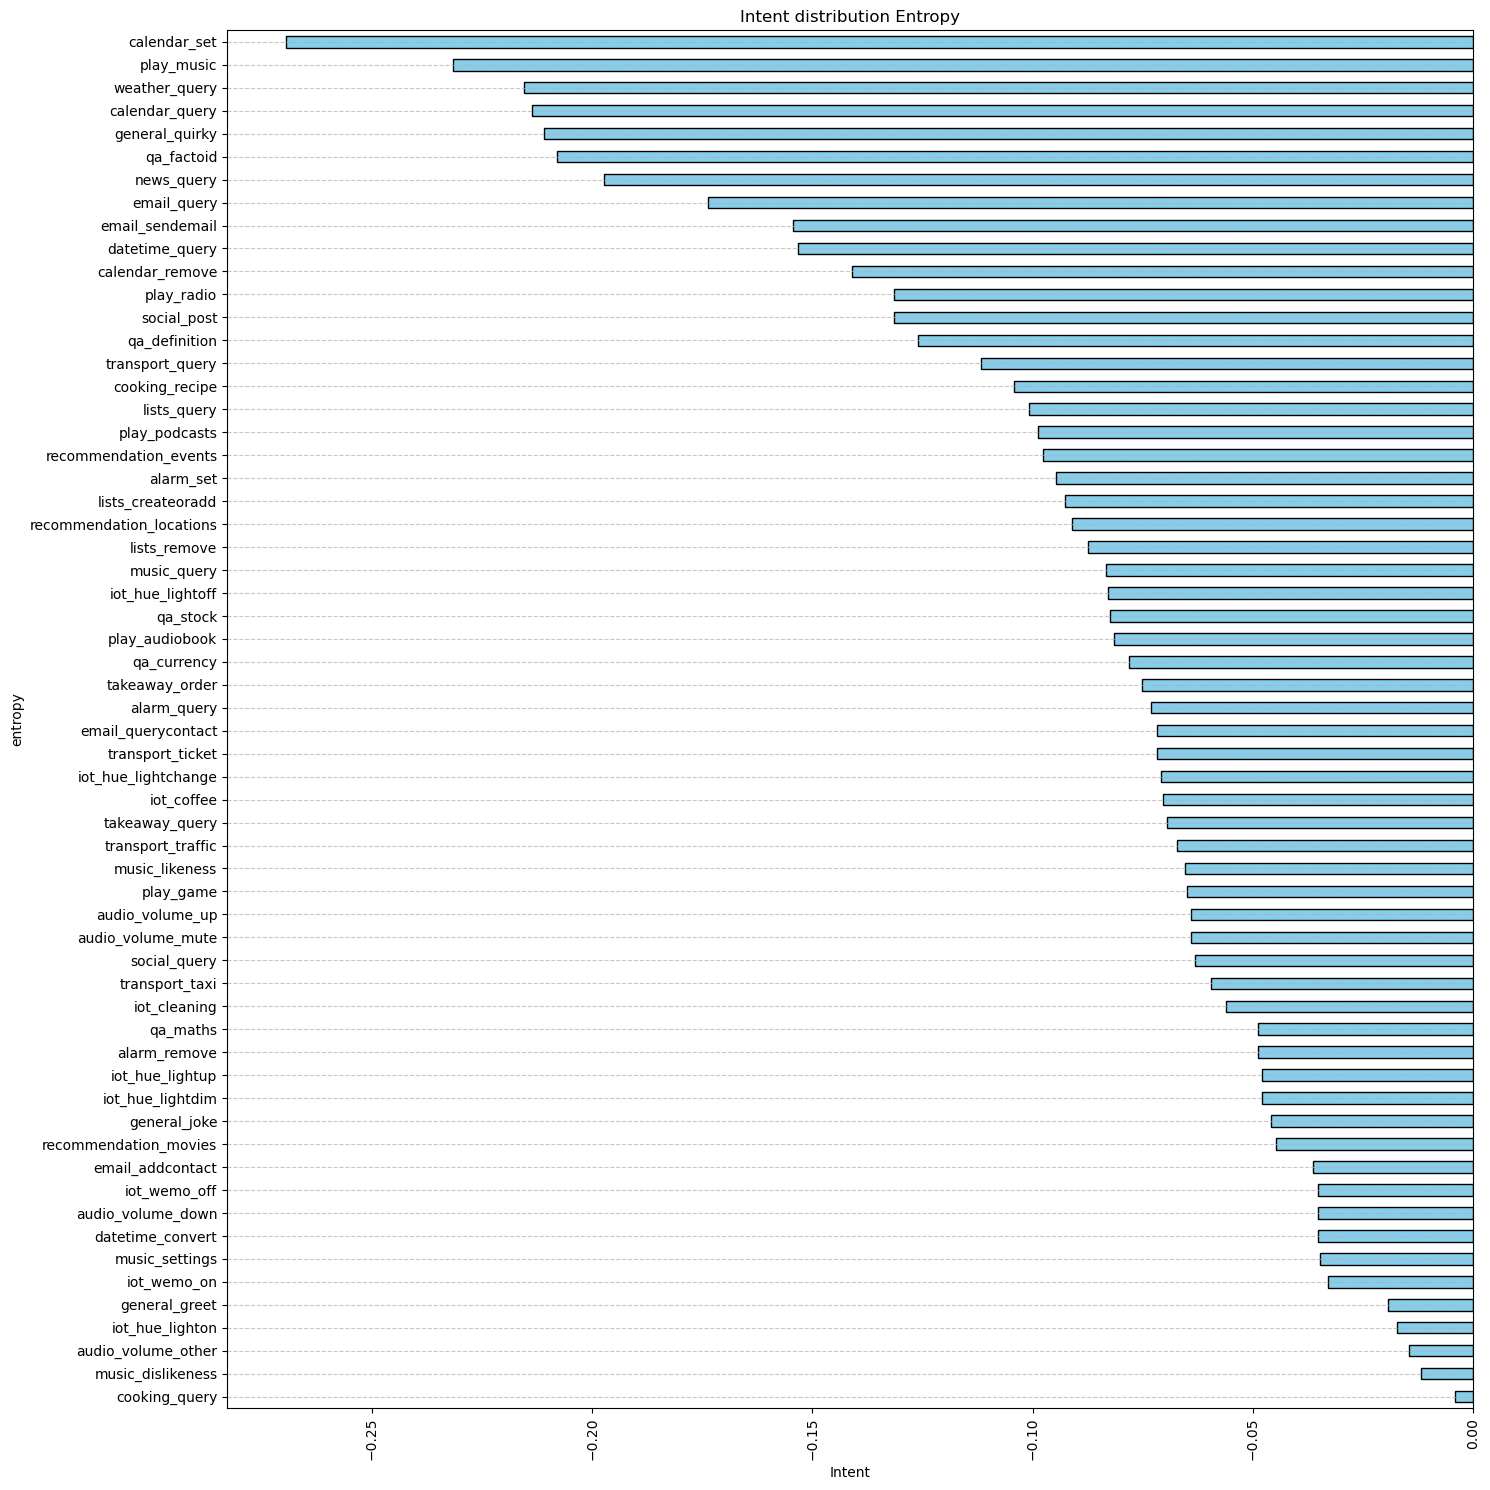

In [17]:
intent_prob = freq_intent / freq_intent.sum()
entropies = intent_prob * np.log2(intent_prob)
total_entropy = entropies.sum()
print(f"entropy for the intents: {total_entropy:.4f}")
plt.figure(figsize=(15,15))
entropies.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Intent distribution Entropy")
plt.xlabel("Intent")
plt.ylabel("entropy")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Model Training

The model as been trained with the `Adam` algorithm.
 Adam (Adaptive Moment Estimation) the model's weight using the exponentially decayng avareg of the past gradients (mₜ) and their squarer (vₜ) to provide stable update:

$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$

$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$

$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$

$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$

$
\theta_t = \theta_{t-1} - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$

The training provided greate resaults on the test dataset, finding a accetable loss function after only 51 iteration:



📊 Risultati sullo split: test
                          precision    recall  f1-score   support

             alarm_query       1.00      1.00      1.00       130
            alarm_remove       1.00      1.00      1.00        78
               alarm_set       1.00      1.00      1.00       182
       audio_volume_down       1.00      1.00      1.00        52
       audio_volume_mute       0.99      0.99      0.99       110
      audio_volume_other       1.00      1.00      1.00        18
         audio_volume_up       1.00      1.00      1.00       110
          calendar_query       0.99      1.00      1.00       566
         calendar_remove       0.99      1.00      1.00       312
            calendar_set       1.00      1.00      1.00       810
           cooking_query       1.00      1.00      1.00         4
          cooking_recipe       1.00      1.00      1.00       207
        datetime_convert       1.00      1.00      1.00        52
          datetime_query       0.99      1.0

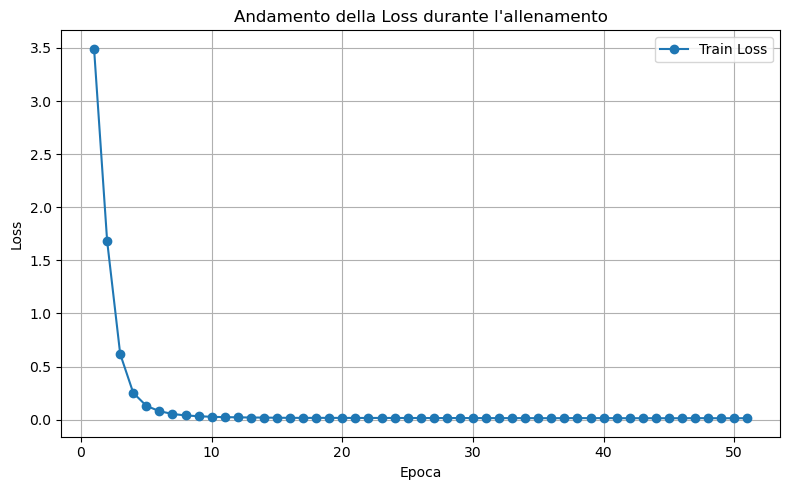

In [2]:
from assistente.training.tester import tester
tester(plt=True)

## Parameters recognition

Most querys contein parameters that are crucial for the execution of a precise command. This brings to the introduction of a second model for the `Token Recognition`

The MASSIVE dataset also contains a fild named *annot_utt*, that specifies the parameters of the query, such as the `time` for the `alarm_set` intent.
As a charatteristic of the dataset, querys that fall in different intent may contain the same kind of parameters. The training must be done considering not only the querys' text but also their classification. 

As for the intents, parameters are not equaly distributed


game_type                  1
music_album                1
sport_type                 5
audiobook_author           6
transport_descriptor       8
alarm_type                 9
transport_name             9
drink_type                 9
movie_type                10
movie_name                16
cooking_type              17
ingredient                18
coffee_type               22
transport_agency          31
email_address             32
email_folder              32
joke_type                 34
music_descriptor          45
change_amount             49
app_name                  51
podcast_name              55
time_zone                 55
playlist_name             61
meal_type                 64
podcast_descriptor        67
audiobook_name            73
personal_info             75
general_frequency         84
game_name                 87
color_type               101
order_type               107
song_name                127
radio_name               132
player_setting           162
music_genre   

<Axes: title={'center': 'parameters frequency'}, xlabel='count', ylabel='parameters'>

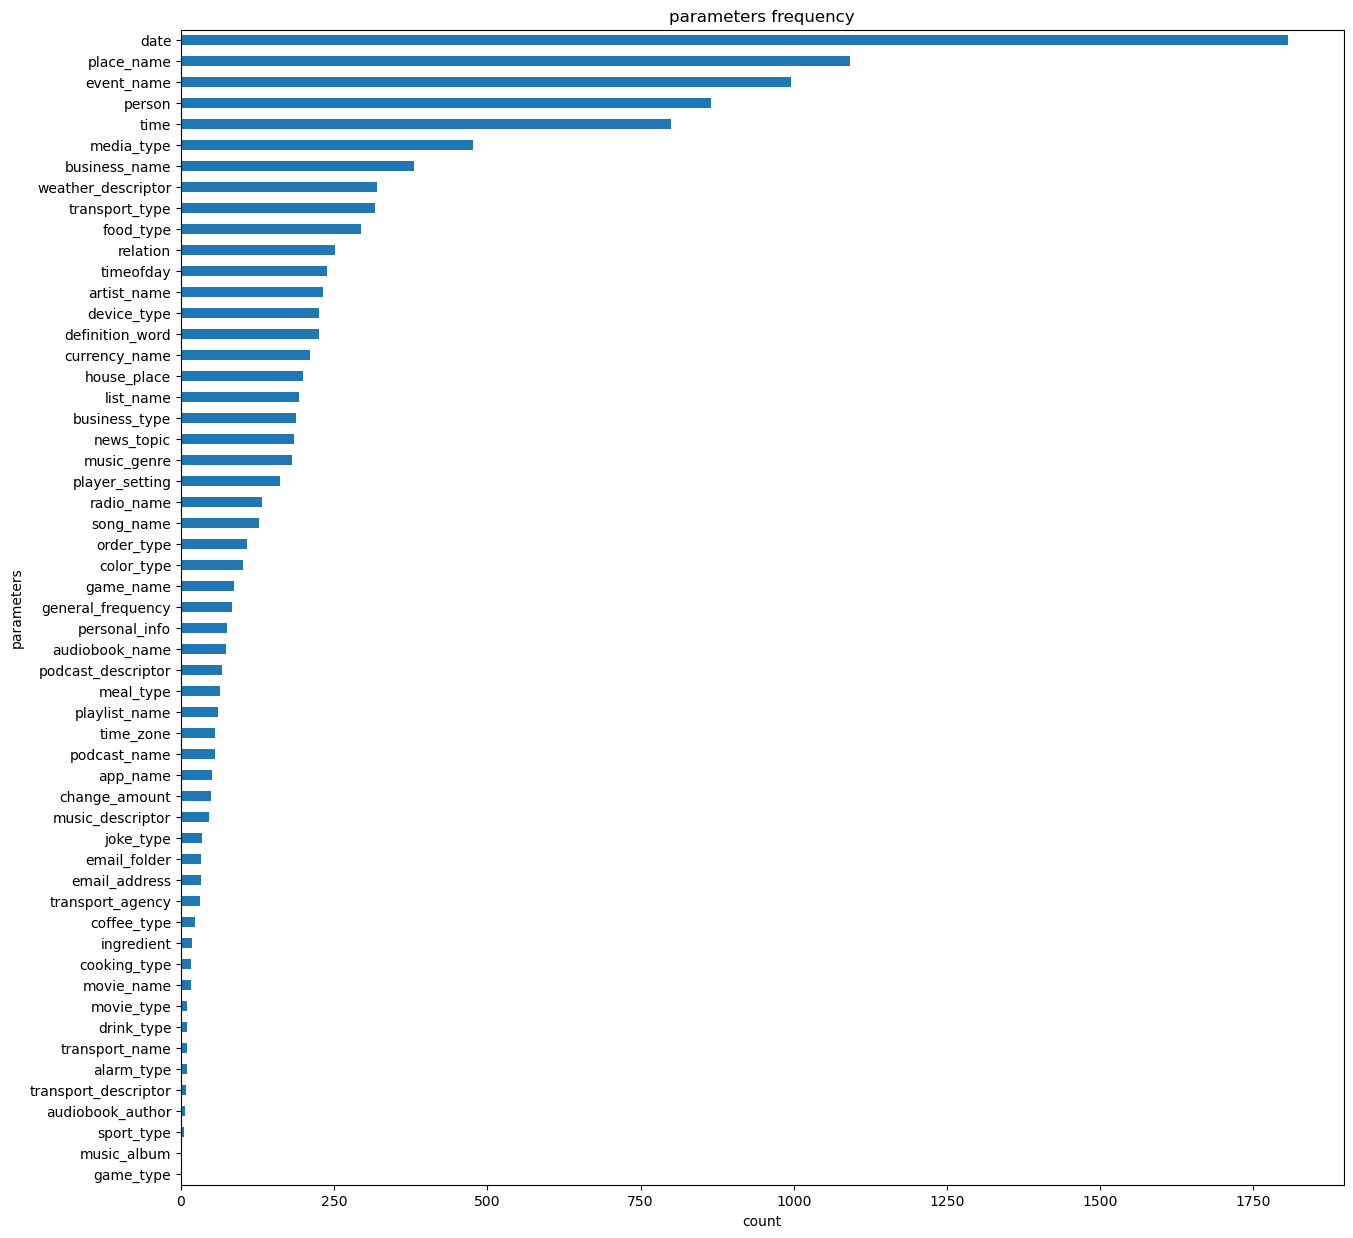

In [8]:
import pandas as pd
import re

SLOT_REGEX = re.compile(r"\[([^:\]]+)\s*:\s*([^\]]+)\]")  # cattura nome_slot e valore

params = []

# cicla su ogni annotazione del DataFrame
for annot in ds['annot_utt']:
    if isinstance(annot, str):  # evita NaN o None
        for match in SLOT_REGEX.finditer(annot):
            slot = match.group(1).strip()
            params.append(slot)

# conta le occorrenze con value_counts()
slot_counts = pd.Series(params).value_counts().sort_values()

# mostra e grafica
print(slot_counts)
slot_counts.plot(kind='barh', figsize=(15, 15), title='parameters frequency', ylabel='parameters', xlabel='count')
